# **Computer Vision** | MSc in Data Science and Engineering
## Assignment 2 - CAPTCHA Decoding
### Bruno Silva (up201508756) **|** João Carvalho (up201507023)
##### November, 2024


## TO DO

Report metrics on image level and on character level \
Report efficiency metrics like run time, number of parameters, number of FLOPs \
Do error analysis:
- identify the worst performing characters, try to improve on that front
- report common patterns like characters that are visibly difficult to identify, characters easily confusing like 0 and O, l and 1, etc. And maybe augment data on these to try to improve the model

Start from a very simple model as a baseline \
Try to get class representation percentages to see if there is any class imbalance \
Consider using grayscale images - maybe first with normal images and then grayscale to see if there's any difference in performance.

Treino:
- Separar todas as imagens em caracteres diferentes e guardar com a respetiva label (temos de ter a ordem porque os caracteres estão por ordem no nome). Basicamente criar um dataset novo. Treinar o modelo nestes caracteres individuais.

Teste:
- A pipeline vai começar por dividir a imagem em caracteres e guarda a ordem. Depois caracter a caracter aplica o modelo para saber que caracter se trata.
- O output são as predictions de cada caracter por ordem.

## Introduction


In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as func
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from torch import nn
import pandas as pd
import numpy as np
import cv2 as cv
import random
import shutil
import torch
import time
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Pre-processing (DO NOT RUN)
This is for the initial segmentation of each image into individual characters for training purposes. In colab this is very slow and unreliable to run (it doesn't manage the upload of 30000+ images well). We also tried using Google Drive as the source of the data but PyTorch's DataLoader is extremely slow on fetching the data from the drive. Our solution was to run the segmentation locally and save everything in a zip file with the character images instead. The unzipping of the zip files is done below and works well with colab.

In [11]:
## Creation of validation set
train_data_folder_soft = "CAPTCHA_dataset/soft/train"
validation_data_folder_soft = "CAPTCHA_dataset/soft/validation"
train_data_folder_hard = "CAPTCHA_dataset/hard/train"
validation_data_folder_hard = "CAPTCHA_dataset/hard/validation"

pairs = [
    (train_data_folder_soft, validation_data_folder_soft),
    (train_data_folder_hard, validation_data_folder_hard)
]

for train_data_folder, validation_data_folder in pairs:
    # choose 20% of the training folder and 
    train_files = os.listdir(train_data_folder)
    random.seed(10) # for reproducibility
    validation_files = random.sample(train_files, int(len(train_files) * 0.2))

    # move to the validateion folder
    for file in validation_files:
        src = os.path.join(train_data_folder, file)
        dst = os.path.join(validation_data_folder, file)
        shutil.move(src, dst)

In [107]:
def segment_char(img_name, data_folder):

    img_path = os.path.join(data_folder, img_name)

    # image to grayscale
    image = cv.imread(img_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # thresholding
    _, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # morphological operations and median blur for the "hard" images
    thresh = dilate(erode(thresh, 2), 2) if "hard" in data_folder else thresh
    thresh = cv.medianBlur(src=thresh, ksize=3) if "hard" in data_folder else thresh

    # contours detection
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # applying a threshold to remove small contours
    threshold = 100
    contours = [contour for contour in contours if cv.contourArea(contour) > threshold]

    # creating individual images based on the bounding boxes
    individual_images = []
    x_values = []
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        x_values.append(x)
        individual_image = image[y:y+h, x:x+w]
        individual_images.append(individual_image)

    # get the sorted idx of x_values -> this is to order the images from left to right, otherwise the contours are ordered in some other way
    sorted_idx = np.argsort(x_values)
    # sort individual_images based on sorted_idx
    individual_images = [individual_images[i] for i in sorted_idx]

    # save individual images
    full_img_name = img_name.split('.')[0]

    return individual_images, full_img_name

def save_images(individual_images, data_folder, full_img_name, img_name):

    # new folder for individual images
    new_data_folder = data_folder + "_char"

    # If the pre-processing is not done correctly, we have a different number of images and characters
    # So, we raise an error for the following step
    if len(individual_images) != len(full_img_name):
        raise ValueError()

    for i, img in enumerate(individual_images):
        char = img_name[i]
        cv.imwrite(f'{new_data_folder}/{char}_{full_img_name}_{i}.png', img)

In [110]:
data_folders = ["CAPTCHA_dataset/soft/", "CAPTCHA_dataset/hard/"]
count_soft = 0
count_hard = 0

hard_wrong_pp = []

for data_folder in data_folders:

    for sub_folder in ['train', 'validation', 'test']:

        iter_data_folder = data_folder + sub_folder

        for img in os.listdir(iter_data_folder):
            try:
                individual_images, full_img_name = segment_char(img, iter_data_folder)
                save_images(individual_images, iter_data_folder, full_img_name, img) # if the error is raised, we continue for the next iteration, ignoring this image
            except:
                if 'soft' in data_folder:
                    count_soft += 1
                else:
                    hard_wrong_pp.append(img)
                    count_hard += 1
                continue

In [111]:
print(f'A total of {count_soft} images were discarded from the soft dataset and {count_hard} from the hard dataset.')

A total of 932 images were discarded from the soft dataset and 1664 from the hard dataset.


In [16]:
print(f'A total of {count_soft} images were discarded from the soft dataset and {count_hard} from the hard dataset.')

A total of 932 images were discarded from the soft dataset and 5885 from the hard dataset.


In [136]:
hard_wrong_pp

['00025.png',
 '00096.png',
 '0028.png',
 '0031.png',
 '01145.png',
 '011xp.png',
 '01248.png',
 '01615.png',
 '0186.png',
 '0196.png',
 '01s6w.png',
 '0215.png',
 '0232.png',
 '0244.png',
 '0292.png',
 '03119.png',
 '03166.png',
 '0348.png',
 '03856.png',
 '0405.png',
 '0406.png',
 '040n5.png',
 '0412.png',
 '04123.png',
 '0429.png',
 '04332.png',
 '04430.png',
 '04532.png',
 '0466.png',
 '0467.png',
 '0492.png',
 '0508.png',
 '05283.png',
 '05499.png',
 '05683.png',
 '0569.png',
 '0577.png',
 '057w.png',
 '06019.png',
 '06329.png',
 '0647.png',
 '0654.png',
 '0655.png',
 '0691.png',
 '06939.png',
 '06mh0.png',
 '07389.png',
 '07865.png',
 '07900.png',
 '0792.png',
 '0828.png',
 '08293.png',
 '0830.png',
 '08446.png',
 '08542.png',
 '08608.png',
 '0866.png',
 '09293.png',
 '0951.png',
 '09650.png',
 '09954.png',
 '09964.png',
 '0fj2u.png',
 '0gxtl.png',
 '0kgh.png',
 '0rbra.png',
 '10292.png',
 '103zk.png',
 '10584.png',
 '1066.png',
 '10727.png',
 '1092.png',
 '11221.png',
 '11289.pn

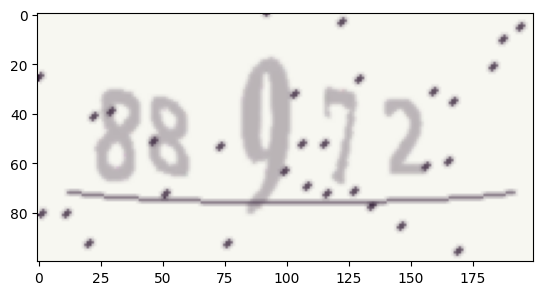

In [121]:
# hard = cv.imread("CAPTCHA_dataset/hard/train/2nbtw.png")
hard = cv.imread("CAPTCHA_dataset/hard/train/88972.png")
hard = cv.cvtColor(hard, cv.COLOR_BGR2RGB)
plt.imshow(hard)

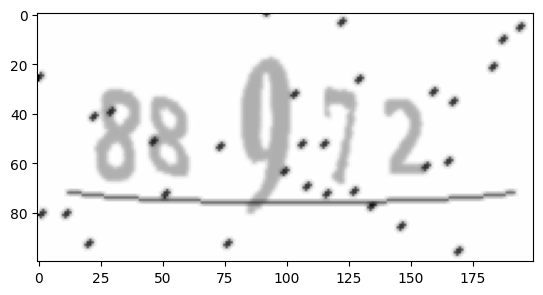

In [122]:
hard_gray = cv.cvtColor(hard, cv.COLOR_RGB2GRAY)
plt.imshow(hard_gray, cmap='gray')

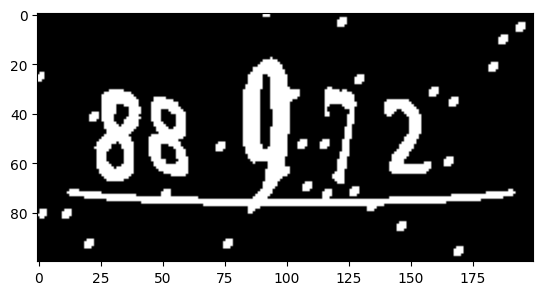

In [123]:
# grabbing contours
_, thresh = cv.threshold(hard_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

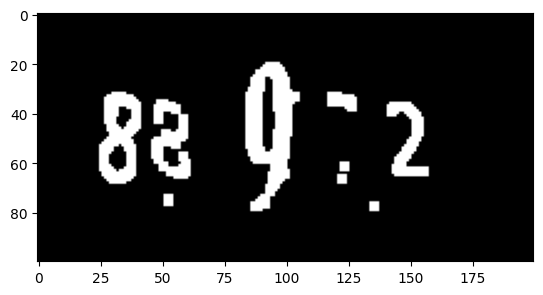

In [133]:
thresh_eroded = dilate(erode(thresh, 4), 4)
plt.imshow(thresh_eroded, cmap='gray')

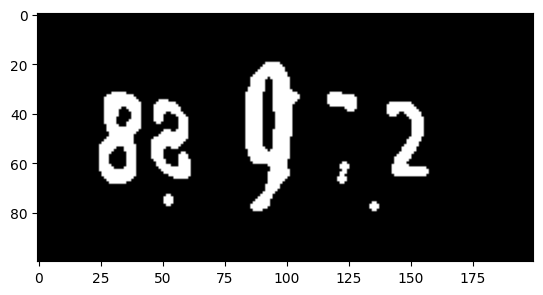

In [134]:
median = cv.medianBlur(src=thresh_eroded, ksize=3)
plt.imshow(median, cmap='gray')

4


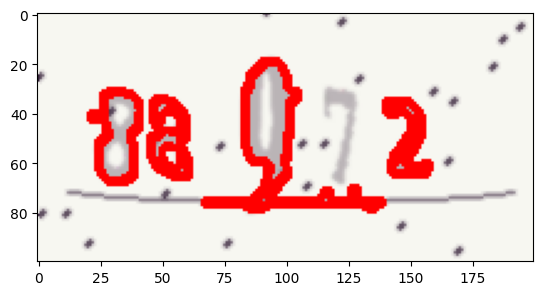

In [135]:
contours, _ = cv.findContours(median, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# applying a threshold to remove small contours
threshold = 100
contours = [contour for contour in contours if cv.contourArea(contour) > threshold]

# drawing contours
cv.drawContours(hard, contours, -1, 255, 2)

print(len(contours))
plt.imshow(hard)
plt.show()

## Image treatment

After segmenting each CAPTCHA image into distinct characters using OpenCV and contour methods we noticed in a few rare examples we would have the issue overlapping characters. This is a problem because if characters overlap, there will be only one contour for two different characters which will segment the image incorrectly. With an incorrect segmentation, the labels (which are extracted from the CAPTCHA image's name) will also be incorrect from that character onwards. \
To solve this issue we tried to find a way to systematically improve the segmentation by separating the characters using methods like erosion or watershed but this didn't prove effective because it would negatively impact the rest of the image. We found no way of systematically improve the segmentation. \
In order to have only high quality data in the training process we decided to remove these cases from the dataset and keep only the segmentations that had the same number of contours as they had characters. This removed 932 images from the whole dataset (train, validation and test sets) from a total of 7773 which is not too bad as the vast makority was kept. \
Some of the experiments were kept below for reference. Please don't run the cells as the original paths are not valid anymore dure to our solution just described. \
NOTE: These misclassifications due to the pre-processing of the images will be accounted for in some of the evaluation metrics presented later on.

In [10]:
# morphological operations

def dilate(array, kernel_size):
    if np.max(array) == 1:
        array2 = (array * 255).astype(np.uint8)
    else:
        array2 = array.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8) 
    array_dilated = cv.dilate(array2, kernel, iterations=1) #dilate
    return array_dilated

def erode(array, kernel_size):
    if np.max(array) == 1:
        array2 = (array * 255).astype(np.uint8)
    else:
        array2 = array.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8) 
    array_eroded = cv.erode(array2, kernel, iterations=1) #erode
    return array_eroded

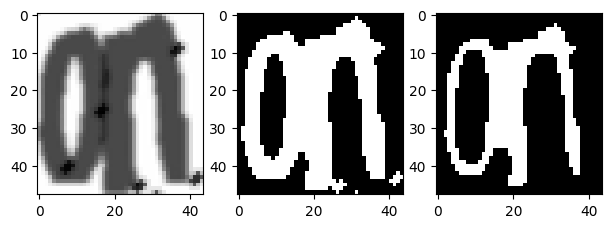

In [ ]:
img_path = "CAPTCHA_dataset/soft/train_char/s_vs0n_1.png"
img = cv.imread(img_path)
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

_, imgThreshold = cv.threshold(img, 150, 255, cv.THRESH_BINARY_INV)

img_eroded = erode(imgThreshold, 3)

plt.figure(figsize=(15,15))
plt.subplot(1,6,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,6,2)
plt.imshow(imgThreshold, cmap='gray')
plt.subplot(1,6,3)
plt.imshow(img_eroded, cmap='gray')

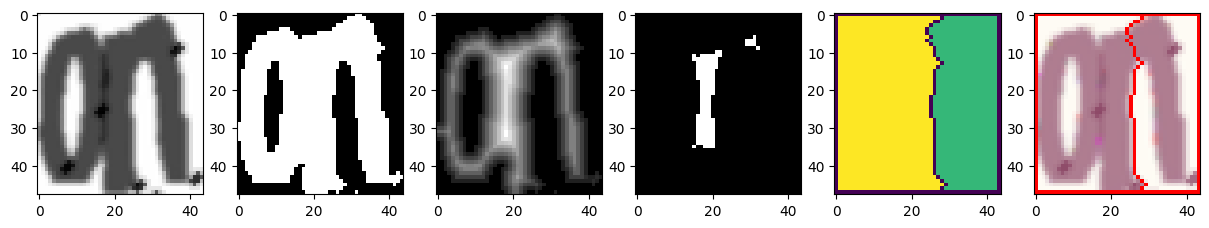

In [ ]:
# WATERSHED ATTEMPT

img_path = "CAPTCHA_dataset/soft/train_char/s_vs0n_1.png"
img = cv.imread(img_path)
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

_, imgThreshold = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)

distTrans = cv.distanceTransform(imgThreshold, cv.DIST_L2, 5) 

_, distThresh = cv.threshold(distTrans, 5, 255, cv.THRESH_BINARY)

distThresh = np.uint8(distThresh)
_, labels = cv.connectedComponents(distThresh)

labels = np.int32(labels)
mask = cv.watershed(imgRGB, labels)

imgRGB[mask == -1] = [255, 0, 0]


plt.figure(figsize=(15,15))
plt.subplot(1,6,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,6,2)
plt.imshow(imgThreshold, cmap='gray')
plt.subplot(1,6,3)
plt.imshow(distTrans, cmap='gray')
plt.subplot(1,6,4)
plt.imshow(distThresh, cmap='gray')
plt.subplot(1,6,5)
plt.imshow(mask)
plt.subplot(1,6,6)
plt.imshow(imgRGB)

## Data

On this section we create the DataLoader objects necessary to develop the model.

In [ ]:
# Unzipping the datasets
'''
This will unzip train_char.zip and test_char.zip both from the hard folder and soft folder.
Make sure to have a CAPTCHA_dataset folder with a /hard and /soft folders inside in the colab directory created before running this cell.
'''
from zipfile import ZipFile

for folder in ["train", "test"]:

    with ZipFile(f"{folder}_char.zip", 'r') as zObject:

        zObject.extractall(path="CAPTCHA_dataset/soft/")

FileNotFoundError: [Errno 2] No such file or directory: 'train_ind.zip'

In [141]:
# to check if all the images are there
print(len([name for name in os.listdir('CAPTCHA_dataset/soft/train_char')])) # should be 20119
print(len([name for name in os.listdir('CAPTCHA_dataset/soft/validation_char')])) # should be 4963
print(len([name for name in os.listdir('CAPTCHA_dataset/soft/test_char')])) # should be 5623
print()
print(len([name for name in os.listdir('CAPTCHA_dataset/hard/train_char')])) # should be 15505
print(len([name for name in os.listdir('CAPTCHA_dataset/hard/validation_char')])) # should be 3846
print(len([name for name in os.listdir('CAPTCHA_dataset/hard/test_char')])) # should be 4974

20119
4963
5623

15505
3846
4974


In [142]:
char_map = {ch: idx for idx, ch in enumerate("0123456789abcdefghijklmnopqrstuvwxyz")}
idx_to_char = {idx: ch for ch, idx in char_map.items()}  # Reverse mapping

char_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [143]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform):

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # getting all image paths and labels
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)

            self.image_paths.append(img_path)

            label = img_name[0] # removing the .png from the name and choosing the first character
            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths) # to get the len(dataset)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label = torch.tensor(char_map[label], dtype=torch.long) # with this we don't need the collate function we had initially
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label

In [144]:
transform = transforms.Compose([
    transforms.Resize((32, 16)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [145]:
# Soft dataset
train_dir_soft = 'CAPTCHA_dataset/soft/train_char'
val_dir_soft = 'CAPTCHA_dataset/soft/validation_char'
test_dir_soft = 'CAPTCHA_dataset/soft/test_char'

train_dataset_soft = CaptchaDataset(root_dir=train_dir_soft, transform=transform)
val_dataset_soft = CaptchaDataset(root_dir=val_dir_soft, transform=transform)
test_dataset_soft = CaptchaDataset(root_dir=test_dir_soft, transform=transform)

train_loader_soft = DataLoader(train_dataset_soft, batch_size=32, shuffle=True, num_workers=0)
val_loader_soft = DataLoader(val_dataset_soft, batch_size=32, shuffle=False, num_workers=0)
test_loader_soft = DataLoader(test_dataset_soft, batch_size=32, shuffle=False, num_workers=0)

# Hard dataset
train_dir_hard = 'CAPTCHA_dataset/hard/train_char'
val_dir_hard = 'CAPTCHA_dataset/hard/validation_char'
test_dir_hard = 'CAPTCHA_dataset/hard/test_char'

train_dataset_hard = CaptchaDataset(root_dir=train_dir_hard, transform=transform)
val_dataset_hard = CaptchaDataset(root_dir=val_dir_hard, transform=transform)
test_dataset_hard = CaptchaDataset(root_dir=test_dir_hard, transform=transform)

train_loader_hard = DataLoader(train_dataset_hard, batch_size=32, shuffle=True, num_workers=0)
val_loader_hard = DataLoader(val_dataset_hard, batch_size=32, shuffle=False, num_workers=0)
test_loader_hard = DataLoader(test_dataset_hard, batch_size=32, shuffle=False, num_workers=0)

In [152]:
print('Soft dataset size')
print('Training:', len(train_dataset_soft))
print('Validation:', len(val_dataset_soft))
print('Test:', len(test_dataset_soft))
print()
print('Hard dataset size')
print('Training:', len(train_dataset_hard))
print('Validation:', len(val_dataset_hard))
print('Test:', len(test_dataset_hard))


Soft dataset size
Training: 20119
Validation: 4963
Test: 5623

Hard dataset size
Training: 15505
Validation: 3846
Test: 4974


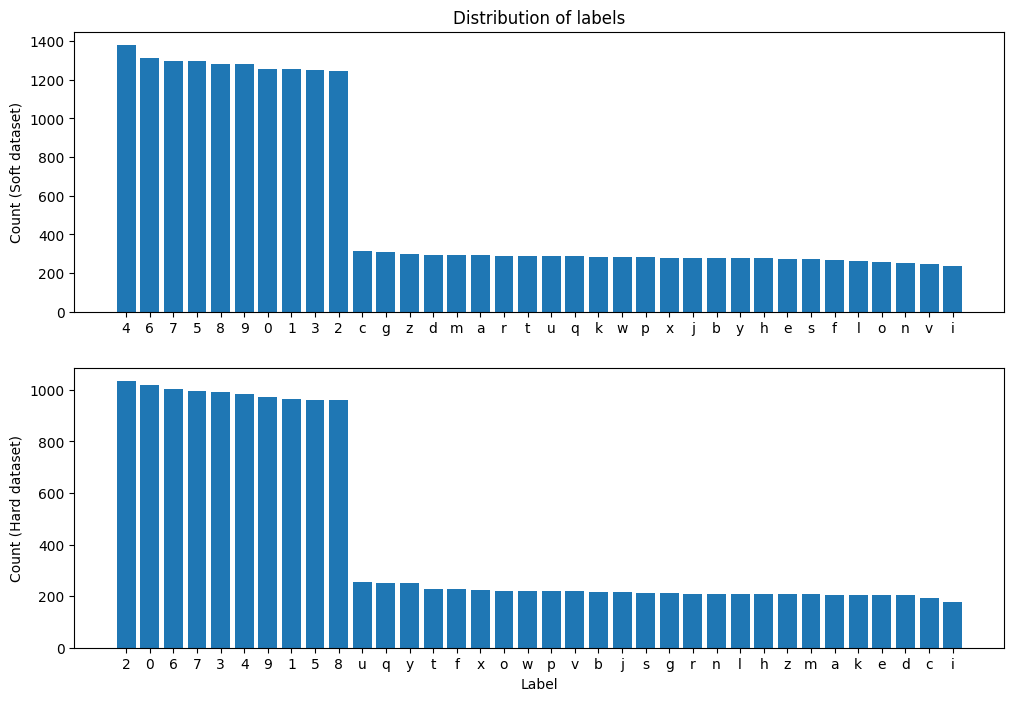

In [157]:
value_counts_soft = pd.Series(train_dataset_soft.labels).value_counts()
value_counts_hard = pd.Series(train_dataset_hard.labels).value_counts()

# plot the distribution of the labels
plt.figure(figsize=(12, 8))
# sns.barplot(x=value_counts.index, y=value_counts.values)
plt.subplot(2, 1, 1)
plt.bar(value_counts_soft.index, value_counts_soft.values)
plt.title('Distribution of labels')
plt.ylabel('Count (Soft dataset)')

plt.subplot(2, 1, 2)
plt.bar(value_counts_hard.index, value_counts_hard.values)
plt.xlabel('Label')
plt.ylabel('Count (Hard dataset)')

plt.show()

In terms of class imbalance, the dataset is not overall balanced, although it is balanced among letters and numbers. Overall there are much more numbers than letters which could be expected given there are only 10 possible numbers and 26 possible letters. \
Later on, we look into the implications of this imabalance.

Image Batch Shape: torch.Size([32, 3, 32, 16])


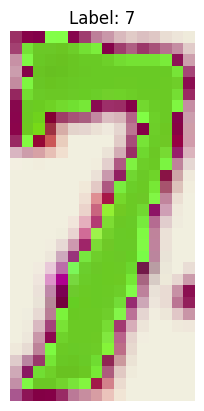

In [159]:
for images, labels in train_loader_soft:
    print("Image Batch Shape:", images.shape)

    # first image in the batch
    first_image = images[0]
    label = labels[0]

    #converting label indices back to characters
    decoded_label = idx_to_char[label.item()]

    # this is for matplotlib to display
    first_image = func.to_pil_image(first_image)

    plt.imshow(first_image)
    plt.title(f"Label: {decoded_label}")
    plt.axis('off')
    plt.show()

    break

## Model

In [160]:
# Baseline Model

class Baseline_CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(Baseline_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 8, 64) # 32x16 after two MaxPooling layers => 8x4
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [161]:
# Model Architecture

class CAPTCHA_CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CAPTCHA_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 8, 256) # 32x16 after two MaxPooling layers => 8x4
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [163]:
def train(train_loader, val_loader, epochs, model, loss_fn, optimizer):

    max_val_accuracy = 0.0
    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}

    print("Started training...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # train accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # save training history for plotting purposes
        train_history["loss"].append(running_loss / len(train_loader))
        train_history["accuracy"].append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                # validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val

        # save validation history for plotting purposes
        val_history["loss"].append(val_loss / len(val_loader))
        val_history["accuracy"].append(val_accuracy)

        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'test.pth')

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    print("Finished")
    total_time = time.time() - start_time
    print(f"Total time: {total_time:.2f} seconds")

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()
            
def eval(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    labels_list = []
    predictions_list = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            labels_list.extend(labels.tolist())
            predictions_list.extend(predicted.tolist())
    
    accuracy = 100 * correct / total
    return accuracy, labels_list, predictions_list

Started training...
Epoch [1/10], Train Loss: 0.9439, Train Accuracy: 73.91%, Validation Loss: 0.3773, Validation Accuracy: 89.65%
Epoch [2/10], Train Loss: 0.3227, Train Accuracy: 90.33%, Validation Loss: 0.2675, Validation Accuracy: 92.54%
Epoch [3/10], Train Loss: 0.2308, Train Accuracy: 92.85%, Validation Loss: 0.2090, Validation Accuracy: 94.38%
Epoch [4/10], Train Loss: 0.1841, Train Accuracy: 93.99%, Validation Loss: 0.2035, Validation Accuracy: 95.03%
Epoch [5/10], Train Loss: 0.1572, Train Accuracy: 94.97%, Validation Loss: 0.1806, Validation Accuracy: 95.40%
Epoch [6/10], Train Loss: 0.1425, Train Accuracy: 95.38%, Validation Loss: 0.1746, Validation Accuracy: 95.66%
Epoch [7/10], Train Loss: 0.1273, Train Accuracy: 95.63%, Validation Loss: 0.1605, Validation Accuracy: 95.79%
Epoch [8/10], Train Loss: 0.1171, Train Accuracy: 96.09%, Validation Loss: 0.1784, Validation Accuracy: 94.64%
Epoch [9/10], Train Loss: 0.1104, Train Accuracy: 96.20%, Validation Loss: 0.1666, Validatio

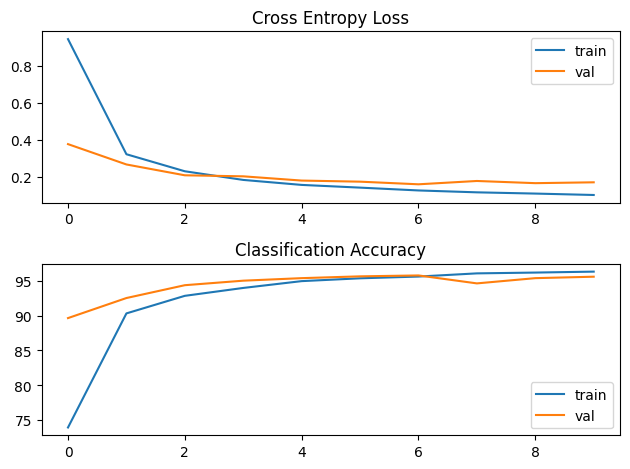

In [164]:
epochs = 10
model = CAPTCHA_CNN(num_classes=36).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train(train_loader_hard, val_loader_hard, epochs, model, loss_fn, optimizer)

In [14]:
model = CAPTCHA_CNN(num_classes=36).to(device)
model.load_state_dict(torch.load('best_model.pth'))

C:\Users\joaoc\AppData\Local\Temp\ipykernel_28644\3801643914.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

## Results

In [165]:
train_accuracy, _, _ = eval(train_loader_hard, model)
val_accuracy, _, _ = eval(val_loader_hard, model)
test_accuracy, _, _ = eval(test_loader_hard, model)

print(f"Train Accuracy: {train_accuracy:.2f}%") # como é que está a dar diferente do de cima?
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Train Accuracy: 97.61%
Validation Accuracy: 95.61%
Test Accuracy: 95.05%


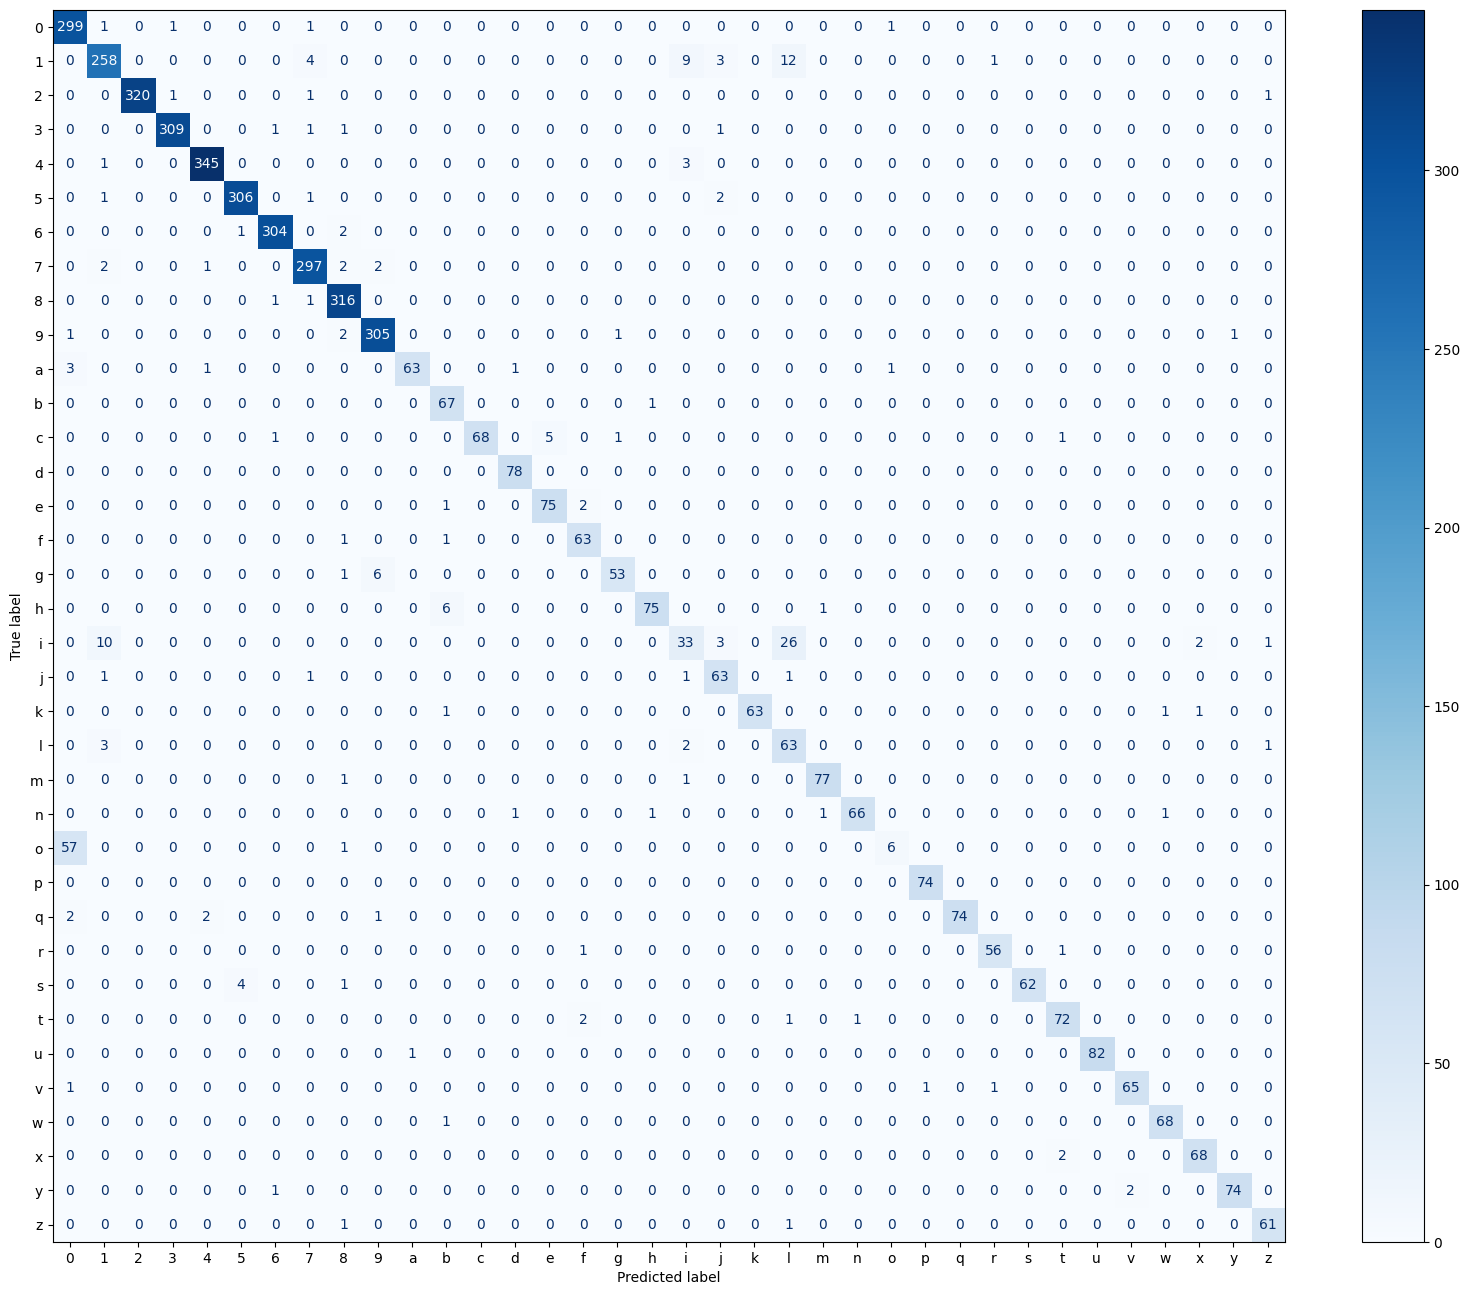

In [167]:
def plot_confusion_matrix(labels, pred_labels, class_labels):
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels, labels=class_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=class_labels)
    cm.plot(values_format='d', cmap='Blues', ax=ax)

_, labels, predictions = eval(test_loader_hard, model)

# convert indexes into characters
labels = [idx_to_char[i] for i in labels]
predictions = [idx_to_char[i] for i in predictions]

# to plot the axes with the class names
class_labels = sorted(set(idx_to_char.values()))

plot_confusion_matrix(labels, predictions, class_labels)

Above we present a confusion matrix applied to the test set. We present it with absolute values since it is easier to understand the distribution of the classes and any issues with class imbalance. We can observe that the model is performing quite well in general due to the well defined diagonal in the matrix. In spite of it, there are two issues we can also observe:
- Most of the times, the model is predicting "0" when the image is showing "o". Out of the 79 "o" characteres, 70 were predicted as a "0". This is likely due to the class imabalance between numbers and letters. Since there are many more "0", the model chooses to predict "0" most of the time. In any case, this is understandable since both characters are very similar and in the context of the CAPTCHA images, even human level performance would be lacking because of the distortion applied to the characters. Below we show one "0" and one "o", which is which?
- The model is also sometimes mixing "i" and "l". Interestingly enough, it doesn't happen the other way around: "l" is almost never confused with an "i".

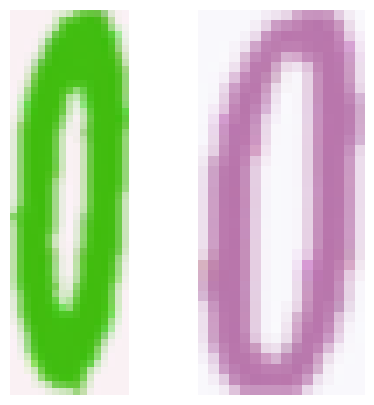

In [ ]:
o_image = cv.imread("CAPTCHA_dataset/soft/test_char/o_0o0mi_1.png")
o_image = cv.cvtColor(o_image, cv.COLOR_BGR2RGB)
z_image = cv.imread("CAPTCHA_dataset/soft/test_char/0_0tqq_0.png")
z_image = cv.cvtColor(z_image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(o_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(z_image)
plt.axis('off')
plt.show()

In [98]:
def classify_random_example(test_loader):
    model.eval()

    # choosing a random batch 
    data_list = list(test_loader)
    random_batch = np.random.randint(0, len(data_list))
    inputs, labels = data_list[random_batch]
    
    # random sample from the batch
    idx = np.random.randint(0, inputs.size(0))
    image, label = inputs[idx], labels[idx]

    image = image.to(device)
    label = label.to(device)

    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)

    image = image.cpu().permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(f"Predicted: {predicted.item()}, Correct: {label.item()}")
    plt.axis('off')
    plt.show()

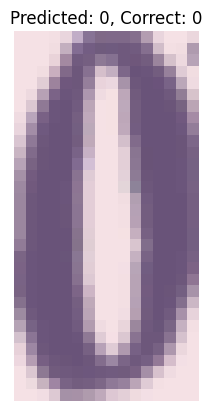

In [100]:
classify_random_example(test_loader)

### Evaluate method

In [168]:
#evaluate method
test_folder = "CAPTCHA_dataset/hard/test"

pre_processing_right = 0
pre_processing_wrong=0
correct = 0
wrong = 0

for img in os.listdir(test_folder):

    # segment individual characters
    individual_images, full_img_name = segment_char(img, test_folder)
    
    # checking if pre-processing worked well
    if len(individual_images)!=len(full_img_name):
        pre_processing_wrong +=1
        wrong+=1

    # if it did, predict
    if len(individual_images)==len(full_img_name):
        pre_processing_right+=1
                
        for i, char_img in enumerate(individual_images):
            # image to tensor
            char_img_pil = Image.fromarray(cv.cvtColor(char_img, cv.COLOR_BGR2RGB))
            char_img_tensor = transform(char_img_pil).unsqueeze(0)

            # model prediction
            with torch.no_grad():
                outputs = model(char_img_tensor)
                _, predicted = torch.max(outputs, 1)
                predicted_char = idx_to_char[predicted.item()]

            # compare with ground truth
            if predicted_char != full_img_name[i]:
                wrong += 1
                break

            if i == len(individual_images) - 1:
                correct += 1

total = correct + wrong
accuracy = (correct / total) * 100
accuracy_tested = (correct / pre_processing_right) * 100

print(f'Accuracy (All): {accuracy:.2f}%')
print(f'Accuracy (Pre-processed): {accuracy_tested:.2f}%')
print(pre_processing_right, pre_processing_wrong)
print(correct)

Accuracy (All): 63.71%
Accuracy (Pre-processed): 82.25%
1110 323
913


Predicted CAPTCHA:  mf4c1
Actual CAPTCHA:  mfac1


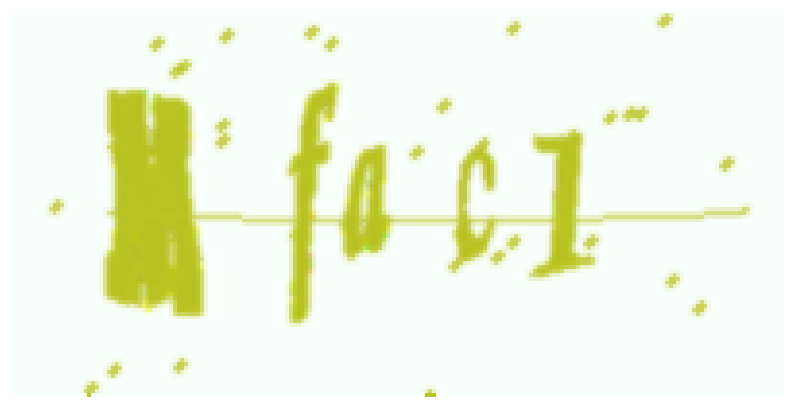

In [208]:
# choosing a random image from the test folder
test_folder = "CAPTCHA_dataset/hard/test"
img = random.choice(os.listdir(test_folder))

# segmenting the characters
individual_images, full_img_name = segment_char(img, test_folder)

# checking if the pre-processing worked
assert len(individual_images)==len(full_img_name), "Pre-processing went wrong! Please run again."

# precition
predicted_str = ""

for i, char_img in enumerate(individual_images):
    # image to tensor
    char_img_pil = Image.fromarray(cv.cvtColor(char_img, cv.COLOR_BGR2RGB))
    char_img_tensor = transform(char_img_pil).unsqueeze(0)

    # model prediction
    with torch.no_grad():
        outputs = model(char_img_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_char = idx_to_char[predicted.item()]

    predicted_str += predicted_char

print('Predicted CAPTCHA: ', predicted_str)
print('Actual CAPTCHA: ', full_img_name)

image = cv.imread(os.path.join(test_folder, img))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()
